# Import modules, model, metrics and data

In [0]:
import pandas as pd
import numpy as np
import xgboost as XGB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import log_loss, make_scorer, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [2]:
X_train_tmp=pd.read_csv('https://s3.amazonaws.com/drivendata/data/54/public/train_values.csv')
display(X_train_tmp.head())
y_train_tmp=pd.read_csv('https://s3.amazonaws.com/drivendata/data/54/public/train_labels.csv')
display(y_train_tmp.head())
X_test=pd.read_csv('https://s3.amazonaws.com/drivendata/data/54/public/test_values.csv')
display(X_test.head())
sample_submission=pd.read_csv('https://s3.amazonaws.com/drivendata/data/54/public/submission_format.csv')
display(sample_submission.head())

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


,patient_id,heart_disease_present
0,0z64un,0
1,ryoo3j,0
2,yt1s1x,1
3,l2xjde,1
4,oyt4ek,0


,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,olalu7,2,reversible_defect,170,1,0,0,2,288,0.2,1,59,159,0
1,z9n6mx,1,normal,138,4,0,0,0,183,1.4,0,35,182,0
2,5k4413,2,reversible_defect,120,4,0,0,2,177,2.5,1,43,120,1
3,mrg7q5,1,normal,102,3,1,0,0,318,0.0,0,60,160,0
4,uki4do,2,normal,138,4,1,0,2,166,3.6,1,61,125,1


,patient_id,heart_disease_present
0,olalu7,0.5
1,z9n6mx,0.5
2,5k4413,0.5
3,mrg7q5,0.5
4,uki4do,0.5


In [3]:
X_train_tmp.dtypes

patient_id                               object
slope_of_peak_exercise_st_segment         int64
thal                                     object
resting_blood_pressure                    int64
chest_pain_type                           int64
num_major_vessels                         int64
fasting_blood_sugar_gt_120_mg_per_dl      int64
resting_ekg_results                       int64
serum_cholesterol_mg_per_dl               int64
oldpeak_eq_st_depression                float64
sex                                       int64
age                                       int64
max_heart_rate_achieved                   int64
exercise_induced_angina                   int64
dtype: object

In [0]:
train_size=X_train_tmp.shape[0]
test_size=X_test.shape[0]

# Feature Engineering

## Combining the features of both training and testing sets

In [0]:
whole_dataset=pd.concat([X_train_tmp, X_test], axis=0)

In [6]:
whole_dataset.nunique()

patient_id                              270
slope_of_peak_exercise_st_segment         3
thal                                      3
resting_blood_pressure                   47
chest_pain_type                           4
num_major_vessels                         4
fasting_blood_sugar_gt_120_mg_per_dl      2
resting_ekg_results                       3
serum_cholesterol_mg_per_dl             144
oldpeak_eq_st_depression                 39
sex                                       2
age                                      41
max_heart_rate_achieved                  90
exercise_induced_angina                   2
dtype: int64

## Using pd.get_dummies on the categorical columns

In [0]:
numeric_columns=set(['resting_blood_pressure', 'serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'age', 'max_heart_rate_achieved'])
categorical_columns=set(whole_dataset.columns).difference(numeric_columns.union(['patient_id']))

In [0]:
for col in categorical_columns:
  whole_dataset[col]=whole_dataset[col].astype('object')

In [9]:
whole_dataset_dummies=whole_dataset.drop(categorical_columns, axis=1)
whole_dataset_dummies=pd.concat([whole_dataset_dummies, pd.get_dummies(whole_dataset[categorical_columns], drop_first=True)], axis=1)
whole_dataset_dummies.head()

,patient_id,resting_blood_pressure,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,age,max_heart_rate_achieved,slope_of_peak_exercise_st_segment_2,slope_of_peak_exercise_st_segment_3,thal_normal,thal_reversible_defect,sex_1,resting_ekg_results_1,resting_ekg_results_2,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,fasting_blood_sugar_gt_120_mg_per_dl_1,exercise_induced_angina_1,num_major_vessels_1,num_major_vessels_2,num_major_vessels_3
0,0z64un,128,308,0.0,45,170,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0
1,ryoo3j,110,214,1.6,54,158,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,yt1s1x,125,304,0.0,77,162,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1
3,l2xjde,152,223,0.0,40,181,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0
4,oyt4ek,178,270,4.2,59,145,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0


## Binning the numeric columns

With an aim to reduce the overfitting of numeric columns, we have to bin these columns. To see the effect of each numeric columns on the columns "heart_disease_present", we first combine the X_train_tmp dataframe with the label.

In [10]:
X_train_tmp_label=pd.concat([whole_dataset_dummies.iloc[:train_size], y_train_tmp], axis=1)
X_train_tmp_label.head()

,patient_id,resting_blood_pressure,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,age,max_heart_rate_achieved,slope_of_peak_exercise_st_segment_2,slope_of_peak_exercise_st_segment_3,thal_normal,thal_reversible_defect,sex_1,resting_ekg_results_1,resting_ekg_results_2,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,fasting_blood_sugar_gt_120_mg_per_dl_1,exercise_induced_angina_1,num_major_vessels_1,num_major_vessels_2,num_major_vessels_3,patient_id,heart_disease_present
0,0z64un,128,308,0.0,45,170,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0z64un,0
1,ryoo3j,110,214,1.6,54,158,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,ryoo3j,0
2,yt1s1x,125,304,0.0,77,162,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,yt1s1x,1
3,l2xjde,152,223,0.0,40,181,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,l2xjde,1
4,oyt4ek,178,270,4.2,59,145,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,oyt4ek,0


### Age

A plot of heart_disease_present against age is plotted.

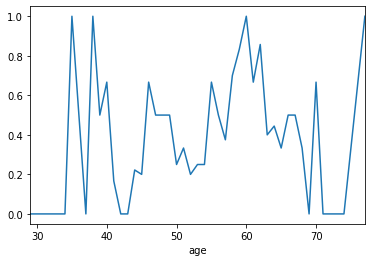

In [11]:
X_train_tmp_label.groupby('age')['heart_disease_present'].mean().plot()


According to the above plot, we can have the following age range.

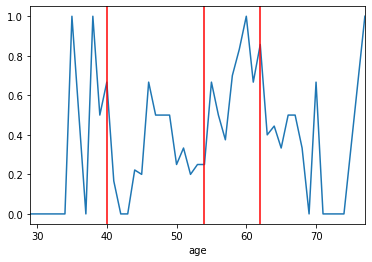

In [12]:
X_train_tmp_label.groupby('age')['heart_disease_present'].mean().plot()
age_range=[0, 40, 54, 62]
for age in age_range:
  plt.axvline(age, c='r')


A function is written for the mapping from age to age_range.

In [0]:
def age_to_bins(age):
  for i in range(len(age_range) - 1):
    if age > age_range[i] and age <= age_range[i+1]:
      return i
  return len(age_range)-1


We apply the funciton on the age columns and see the value_count

In [14]:
whole_dataset_dummies['age_range']=whole_dataset_dummies['age'].transform(age_to_bins)
whole_dataset_dummies['age_range'].value_counts()


1    117
2     84
3     54
0     15
Name: age_range, dtype: int64

Then, we do the same things on other numeric columns.

### Max_heart_rate_achieved

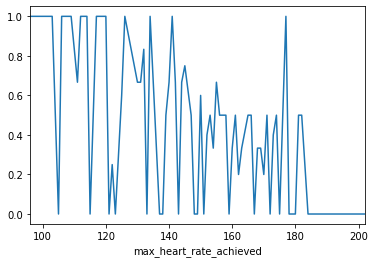

In [15]:
X_train_tmp_label.groupby('max_heart_rate_achieved')['heart_disease_present'].mean().plot()

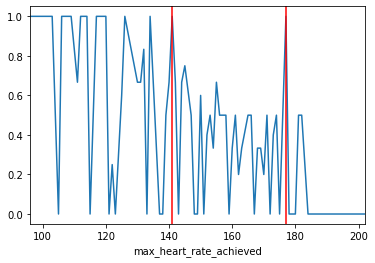

In [16]:
X_train_tmp_label.groupby('max_heart_rate_achieved')['heart_disease_present'].mean().plot()
max_heart_rate_achieved_range=[0, 141, 177]
for max_heart_rate_achieved in max_heart_rate_achieved_range:
  plt.axvline(max_heart_rate_achieved, c='r')


In [0]:
def max_heart_rate_achieved_to_bins(max_heart_rate_achieved):
  for i in range(len(max_heart_rate_achieved_range) - 1):
    if max_heart_rate_achieved > max_heart_rate_achieved_range[i] and max_heart_rate_achieved <= max_heart_rate_achieved_range[i+1]:
      return i
  return len(max_heart_rate_achieved_range)-1


In [18]:
whole_dataset_dummies['max_heart_rate_achieved_range']=whole_dataset_dummies['max_heart_rate_achieved'].transform(max_heart_rate_achieved_to_bins)
whole_dataset_dummies['max_heart_rate_achieved_range'].value_counts()


1    158
0     84
2     28
Name: max_heart_rate_achieved_range, dtype: int64

### Oldpeak_eq_st_depression

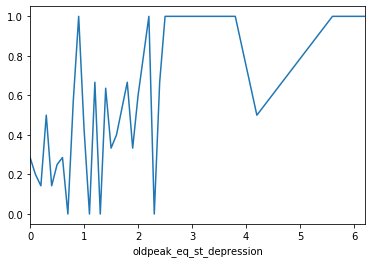

In [19]:
X_train_tmp_label.groupby('oldpeak_eq_st_depression')['heart_disease_present'].mean().plot()

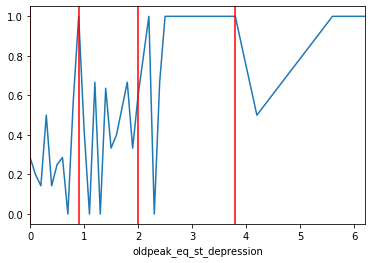

In [20]:
X_train_tmp_label.groupby('oldpeak_eq_st_depression')['heart_disease_present'].mean().plot()
oldpeak_eq_st_depression_range=[0, 0.9, 2, 3.8]
for oldpeak_eq_st_depression in oldpeak_eq_st_depression_range:
  plt.axvline(oldpeak_eq_st_depression, c='r')


In [0]:
def oldpeak_eq_st_depression_to_bins(oldpeak_eq_st_depression):
  for i in range(len(max_heart_rate_achieved_range) - 1):
    if oldpeak_eq_st_depression > oldpeak_eq_st_depression_range[i] and oldpeak_eq_st_depression <= oldpeak_eq_st_depression_range[i+1]:
      return i
  return len(oldpeak_eq_st_depression_range)-1


In [22]:
whole_dataset_dummies['oldpeak_eq_st_depression_range']=whole_dataset_dummies['oldpeak_eq_st_depression'].transform(oldpeak_eq_st_depression_to_bins)
whole_dataset_dummies['oldpeak_eq_st_depression_range'].value_counts()


3    129
1     81
0     60
Name: oldpeak_eq_st_depression_range, dtype: int64

### Resting_blood_pressure

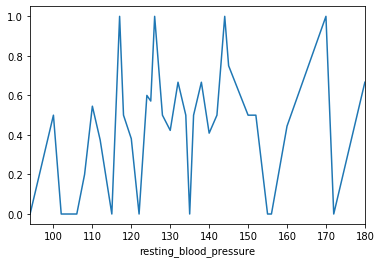

In [23]:
X_train_tmp_label.groupby('resting_blood_pressure')['heart_disease_present'].mean().plot()

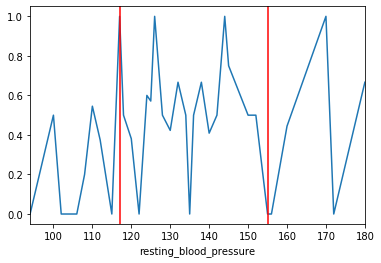

In [24]:
X_train_tmp_label.groupby('resting_blood_pressure')['heart_disease_present'].mean().plot()
resting_blood_pressure_range=[0, 117, 155]
for resting_blood_pressure in resting_blood_pressure_range:
  plt.axvline(resting_blood_pressure, c='r')


In [0]:
def resting_blood_pressure_to_bins(resting_blood_pressure):
  for i in range(len(resting_blood_pressure_range) - 1):
    if resting_blood_pressure > resting_blood_pressure_range[i] and resting_blood_pressure <= resting_blood_pressure_range[i+1]:
      return i
  return len(resting_blood_pressure_range)-1


In [26]:
whole_dataset_dummies['resting_blood_pressure_range']=whole_dataset_dummies['resting_blood_pressure'].transform(resting_blood_pressure_to_bins)
whole_dataset_dummies['resting_blood_pressure_range'].value_counts()


1    195
0     50
2     25
Name: resting_blood_pressure_range, dtype: int64

### Serum_cholesterol_mg_per_dl

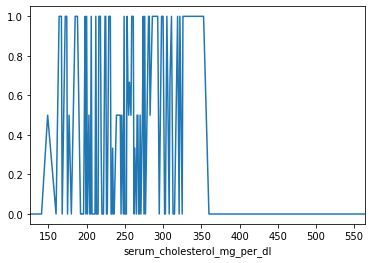

In [27]:
X_train_tmp_label.groupby('serum_cholesterol_mg_per_dl')['heart_disease_present'].mean().plot()

Since the serum_cholesterol_mg_per_dl column is quite noisy, we do not repeat the above steps on it.

### Apply pd.get_dummies on the binned columns

In [0]:
original_columns=['age', 'max_heart_rate_achieved', 'oldpeak_eq_st_depression', 'resting_blood_pressure']
binned_columns=['age_range', 'max_heart_rate_achieved_range', 'oldpeak_eq_st_depression_range', 'resting_blood_pressure_range']

drop_original=True
if drop_original:
  whole_dataset_dummies.drop(original_columns, axis=1, inplace=True)

for col in binned_columns:
  whole_dataset_dummies[col]=whole_dataset_dummies[col].astype('object')


In [29]:

whole_dataset_dummies=pd.concat([whole_dataset_dummies.drop(binned_columns, axis=1), pd.get_dummies(whole_dataset_dummies[binned_columns], drop_first=True)], axis=1)
whole_dataset_dummies.head()

,patient_id,serum_cholesterol_mg_per_dl,slope_of_peak_exercise_st_segment_2,slope_of_peak_exercise_st_segment_3,thal_normal,thal_reversible_defect,sex_1,resting_ekg_results_1,resting_ekg_results_2,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,fasting_blood_sugar_gt_120_mg_per_dl_1,exercise_induced_angina_1,num_major_vessels_1,num_major_vessels_2,num_major_vessels_3,age_range_1,age_range_2,age_range_3,max_heart_rate_achieved_range_1,max_heart_rate_achieved_range_2,oldpeak_eq_st_depression_range_1,oldpeak_eq_st_depression_range_3,resting_blood_pressure_range_1,resting_blood_pressure_range_2
0,0z64un,308,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0
1,ryoo3j,214,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0
2,yt1s1x,304,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,1,0,0,1,1,0
3,l2xjde,223,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0
4,oyt4ek,270,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1


## Separate the dataset to train and test set

In [0]:
X_train_tmp_dummies=whole_dataset_dummies.drop('patient_id', axis=1).iloc[:train_size,:]
X_test_dummies=whole_dataset_dummies.drop('patient_id', axis=1).iloc[train_size:,:]
y_train_tmp.drop('patient_id', axis=1, inplace=True)


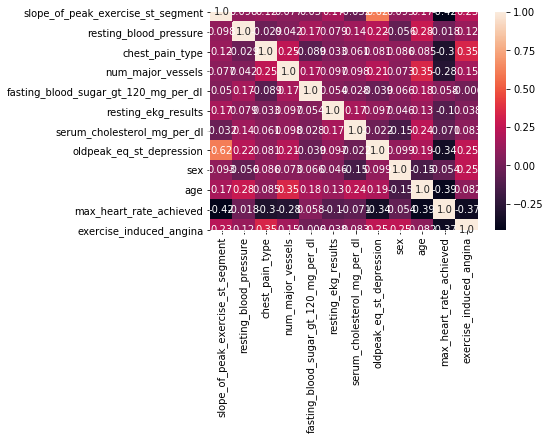

In [31]:
sns.heatmap(X_train_tmp.corr(), annot=True, fmt='.2', )

In [32]:
X_train, X_val, y_train, y_val=train_test_split(X_train_tmp_dummies, y_train_tmp, test_size=0.2, random_state=42)
X_val.shape

(36, 25)

# Model

## XGB

In [0]:
params={'max_depth': [1,2,3,4,5],
        'learning_rate': [.01,.05,.1,.2,.3,.4,.5],
        'n_estimators': [20,25,50,75,100,200],
        'colsample_bytree': [.1,.2,.3,]#.5,.7,.9,1.],
       }
nfold=10

In [34]:
xgbclassifier=XGB.XGBClassifier(n_job=-1,seed=43)
gridsearchcv_xgb=GridSearchCV(xgbclassifier, params, cv=nfold, n_jobs=-1, scoring='neg_log_loss',verbose =1)
gridsearchcv_xgb.fit(X_train_tmp_dummies, y_train_tmp)
print(gridsearchcv_xgb.best_score_)
print(gridsearchcv_xgb.best_params_)


Fitting 10 folds for each of 630 candidates, totalling 6300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 1388 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 3388 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6188 tasks      | elapsed:  2.3min


-0.381219303357001
{'colsample_bytree': 0.1, 'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 50}


[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed:  2.4min finished
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
xgbclassifier=gridsearchcv_xgb.best_estimator_
#xgb_best=xgbclassifier=XGB.XGBClassifier(n_job=-1,seed=43,colsample_bytree=0.2,learning_rate=0.2,max_depth=2,n_estimators=50)
xgbclassifier.fit(X_train_tmp_dummies, y_train_tmp)
y_test_prob_xgb=xgbclassifier.predict_proba(X_test_dummies)[:,1]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


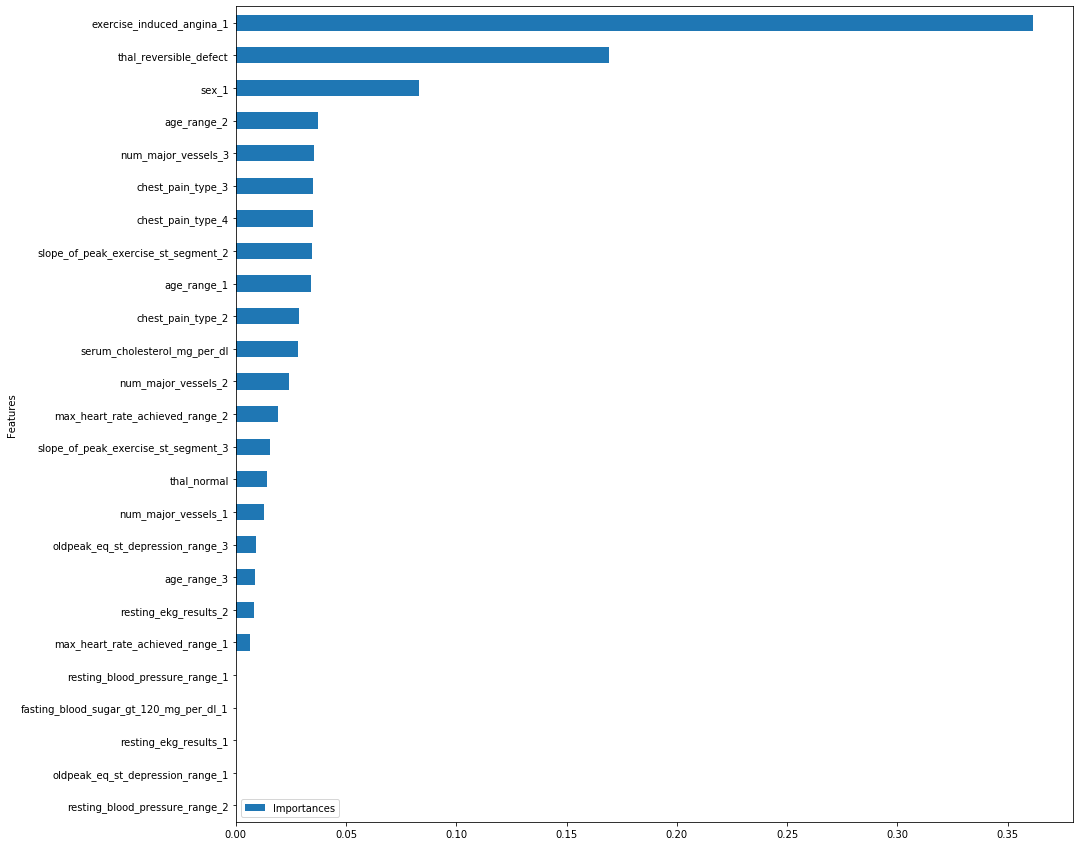

In [36]:
fig, ax=plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)
importances=pd.DataFrame({'Features':X_train_tmp_dummies.columns,'Importances':xgbclassifier.feature_importances_}).set_index('Features')
importances=importances.sort_values(by='Importances', ascending=True)
importances.plot(kind='barh', ax=ax)


In [0]:
#xgbclassifier=XGB.XGBClassifier(max_depth=3, learning_rate=0.01, n_estimators=50, n_job=-1, colsample_bytree =0.5, )
#xgbclassifier.fit(X_train, y_train)

In [38]:
print(xgbclassifier.score(X_train, y_train))
print(xgbclassifier.score(X_val, y_val))

0.875
0.9166666666666666


## Random Forest

In [0]:
params={
       'n_estimators':[1,2,5,10,20,50,100,200],
       'max_depth':[1,2,5,10,20],
       'max_features':[.5,.6,.7,.8,.9,1.],
      }
nfold=10

In [40]:
rfc=RandomForestClassifier(random_state=43, n_jobs=-1)

gridsearchcv_rfc=GridSearchCV(rfc, params, cv=nfold, n_jobs=-1, scoring='neg_log_loss',verbose =1)
gridsearchcv_rfc.fit(X_train_tmp_dummies, y_train_tmp)
print(gridsearchcv_rfc.best_score_)
print(gridsearchcv_rfc.best_params_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  4.5min


-0.4655283065814731
{'max_depth': 2, 'max_features': 0.7, 'n_estimators': 5}


[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  6.0min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [41]:
rfc=gridsearchcv_rfc.best_estimator_
rfc.fit(X_train_tmp_dummies, y_train_tmp)
y_test_prob_rfc=rfc.predict_proba(X_test_dummies)[:,1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


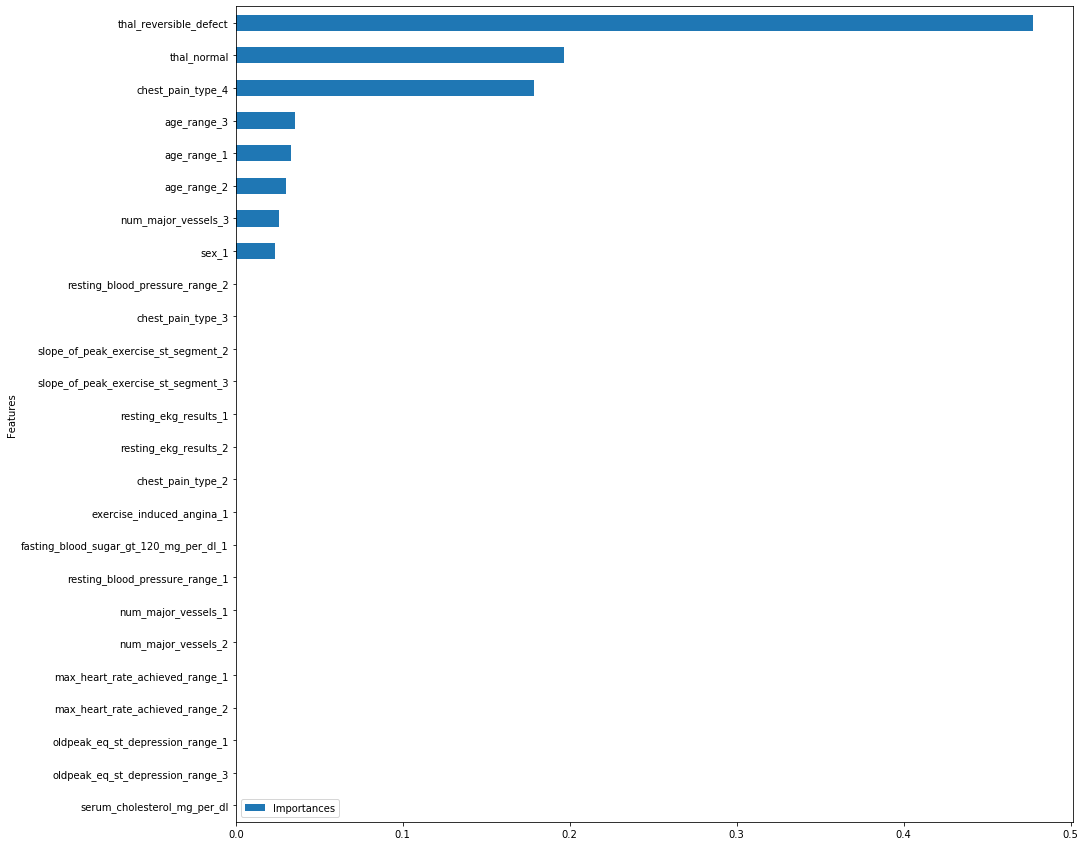

In [42]:
fig, ax=plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)
importances=pd.DataFrame({'Features':X_train_tmp_dummies.columns,'Importances':rfc.feature_importances_}).set_index('Features')
importances=importances.sort_values(by='Importances', ascending=True)
importances.plot(kind='barh', ax=ax)


In [43]:
print(rfc.score(X_train, y_train))
print(rfc.score(X_val, y_val))

0.7708333333333334
0.7777777777777778


## Logistic Regression

In [0]:
feature_scaler=StandardScaler()
X_train_tmp_scaled=feature_scaler.fit_transform(X_train_tmp_dummies)
X_test_scaled=feature_scaler.transform(X_test_dummies)

In [0]:
params={
        'C': [.05,.1, .2,.5,1.],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter':[50, 100, 150, 200]
        }
nfold=10

In [46]:
logreg=LogisticRegression(random_state=43, n_jobs=-1)

gridsearchcv_logreg=GridSearchCV(logreg, params, cv=nfold, n_jobs=-1, scoring='neg_log_loss',verbose =1)
gridsearchcv_logreg.fit(X_train_tmp_scaled, y_train_tmp)
print(gridsearchcv_logreg.best_score_)
print(gridsearchcv_logreg.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 698 tasks      | elapsed:   32.7s


-0.39398249238814087
{'C': 0.1, 'max_iter': 50, 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [47]:
logreg=gridsearchcv_logreg.best_estimator_
logreg.fit(X_train_tmp_scaled, y_train_tmp)
y_test_prob_logreg=logreg.predict_proba(X_test_scaled)[:,1]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


## SVM

In [0]:
feature_scaler=StandardScaler()
X_train_tmp_scaled=feature_scaler.fit_transform(X_train_tmp_dummies)
X_test_scaled=feature_scaler.transform(X_test_dummies)

In [0]:
params={
    'C': [.1,.2,.5,1.,2.],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid',],
    'degree':[1,2,],
    'gamma':['auto'],
    'max_iter':[50,100,150,200],
    'coef0':[.2,.5,1.,2.]
}
nfold=10

In [50]:
svm=SVC(probability=True, random_state=43,)

gridsearchcv_svm=GridSearchCV(svm, params, cv=nfold, n_jobs=-1, scoring='neg_log_loss',verbose =1)
gridsearchcv_svm.fit(X_train_tmp_scaled, y_train_tmp)
print(gridsearchcv_svm.best_score_)
print(gridsearchcv_svm.best_params_)

Fitting 10 folds for each of 640 candidates, totalling 6400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 2730 tasks      | elapsed:   24.4s


-0.37821733659832224
{'C': 1.0, 'coef0': 0.2, 'degree': 1, 'gamma': 'auto', 'kernel': 'sigmoid', 'max_iter': 100}


[Parallel(n_jobs=-1)]: Done 6400 out of 6400 | elapsed:   52.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [51]:
svm=gridsearchcv_svm.best_estimator_
svm.fit(X_train_tmp_scaled, y_train_tmp)
y_test_prob_svm=svm.predict_proba(X_test_scaled)[:,1]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


## AdaBoost

In [0]:
feature_scaler=StandardScaler()
X_train_tmp_scaled=feature_scaler.fit_transform(X_train_tmp_dummies)
X_test_scaled=feature_scaler.transform(X_test_dummies)

In [0]:
params={
        'n_estimators':[10,20,50,100],
        'learning_rate':[.05,.1,.2,.5],
        }

In [54]:
adaboost=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,random_state=43),random_state=43)

gridsearchcv_adaboost=GridSearchCV(adaboost, params, cv=nfold, n_jobs=-1, scoring='neg_log_loss',verbose =1)
gridsearchcv_adaboost=gridsearchcv_adaboost.fit(X_train_tmp_scaled, y_train_tmp)
print(gridsearchcv_adaboost.best_score_)
print(gridsearchcv_adaboost.best_params_)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    6.1s


-0.5454518607100839
{'learning_rate': 0.1, 'n_estimators': 100}


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   13.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Submission


In [0]:
submission=sample_submission.copy()
submission.heart_disease_present=(y_test_prob_xgb+y_test_prob_svm+y_test_prob_logreg)/3#+y_test_prob_rfc)/4

In [0]:
submission.to_csv('submission.csv',index=False)

In [0]:
from google.colab import files


files.download('submission.csv')